### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [5]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

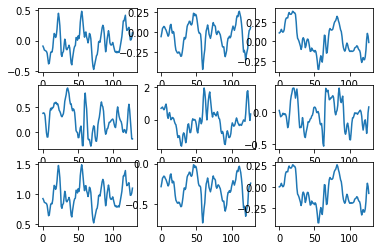

In [6]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [7]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [8]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [9]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Reshape, Conv2D, Input, MaxPooling2D

# GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Single Layer SimpleRNN

In [11]:
### START YOUR CODE

model = Sequential([
    SimpleRNN(units=512, input_shape=(None, 9), return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")

### END YOUR CODE

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 512)               267264    
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 270,342
Trainable params: 270,342
Non-trainable params: 0
_________________________________________________________________


In [12]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 12s 48ms/step - loss: 1.1935 - accuracy: 0.4860 - val_loss: 1.1959 - val_accuracy: 0.4815
Epoch 2/10
230/230 [==============================] - 10s 45ms/step - loss: 0.9448 - accuracy: 0.5993 - val_loss: 1.2627 - val_accuracy: 0.5127
Epoch 3/10
230/230 [==============================] - 10s 45ms/step - loss: 1.0401 - accuracy: 0.5888 - val_loss: 0.8873 - val_accuracy: 0.6525
Epoch 4/10
230/230 [==============================] - 11s 46ms/step - loss: 0.7882 - accuracy: 0.6766 - val_loss: 0.7685 - val_accuracy: 0.7109
Epoch 5/10
230/230 [==============================] - 10s 45ms/step - loss: 0.6584 - accuracy: 0.7344 - val_loss: 1.2389 - val_accuracy: 0.5541
Epoch 6/10
230/230 [==============================] - 11s 47ms/step - loss: 1.0218 - accuracy: 0.5825 - val_loss: 0.8123 - val_accuracy: 0.6854
Epoch 7/10
230/230 [==============================] - 11s 47ms/step - loss: 0.6337 - accuracy: 0.7498 - val_loss: 1.2670 - val_accuracy:

Train accuracy (end): 0.373775839805603
Train accuracy (max): 0.7381665110588074
Test accuracy (end) : 0.35154393315315247
Test accuracy (max) : 0.7108924388885498


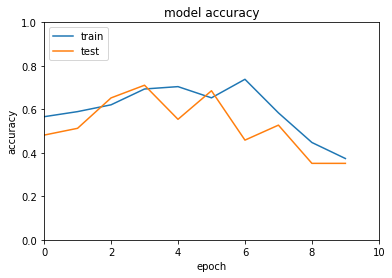

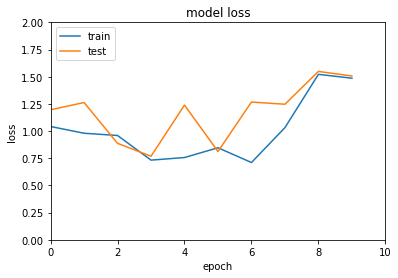

,walk,up,down,sit,stand,lay
walk,0,0,0,0,402,94
up,0,0,0,0,370,101
down,0,0,0,0,340,80
sit,0,0,0,0,341,150
stand,0,0,0,0,527,5
lay,0,0,0,0,28,509


In [13]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

This simple model already achieved a test accuracy of 86.5% at max. After the 7th epoch the training seems to have collapsed which is most probably due to an exploding gradient problem as the used sequence is quite long (`128` steps).

### Stacked Simple RNNs

In [14]:
### START YOUR CODE

model = Sequential([
    SimpleRNN(units=256, input_shape=(None, 9), return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=512, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=1024, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 256)         68096     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 512)         393728    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1024)              1573888   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 2,041,862
Trainable params: 2,041,862
Non-trainable params: 0
_________________________________________________________________


In [15]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 34s 144ms/step - loss: 0.7882 - accuracy: 0.6836 - val_loss: 0.5134 - val_accuracy: 0.8619
Epoch 2/10
230/230 [==============================] - 33s 146ms/step - loss: 0.2303 - accuracy: 0.9118 - val_loss: 0.5331 - val_accuracy: 0.8354
Epoch 3/10
230/230 [==============================] - 33s 145ms/step - loss: 0.2432 - accuracy: 0.9081 - val_loss: 0.5294 - val_accuracy: 0.8548
Epoch 4/10
230/230 [==============================] - 33s 145ms/step - loss: 0.1783 - accuracy: 0.9313 - val_loss: 0.3431 - val_accuracy: 0.8972
Epoch 5/10
230/230 [==============================] - 33s 145ms/step - loss: 0.1667 - accuracy: 0.9336 - val_loss: 0.3152 - val_accuracy: 0.9019
Epoch 6/10
230/230 [==============================] - 33s 141ms/step - loss: 0.1229 - accuracy: 0.9492 - val_loss: 0.3974 - val_accuracy: 0.8870
Epoch 7/10
230/230 [==============================] - 33s 144ms/step - loss: 0.2304 - accuracy: 0.9235 - val_loss: 0.3950 - val_ac

Train accuracy (end): 0.9276387095451355
Train accuracy (max): 0.946273148059845
Test accuracy (end) : 0.6487953662872314
Test accuracy (max) : 0.9019341468811035


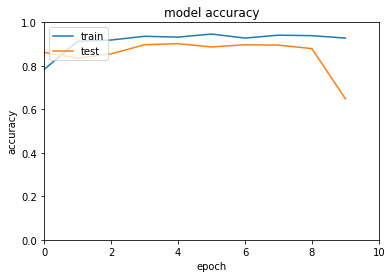

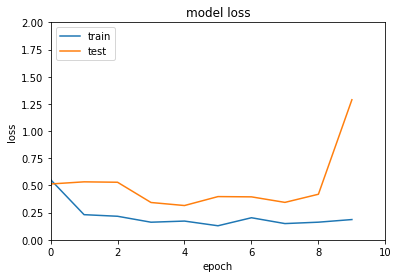

,walk,up,down,sit,stand,lay
walk,375,0,11,70,40,0
up,201,64,31,46,126,3
down,29,1,357,13,20,0
sit,0,0,0,466,25,0
stand,0,0,0,392,140,0
lay,0,0,0,0,27,510


In [16]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Using stacked SimpleRNN layers seems to prevent the exploding gradient problem somehow, but this could also be due to a lucky initialization and short training time. The additional layers bring an test accuray improvement and enable a score of 88.7% at max.

### Several CNN Layers

In [17]:
### START YOUR CODE

model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=(128, 9), activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Flatten(),
    Dense(units=512, activation='relu', kernel_initializer='he_normal'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 32)           896       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 58, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 27, 128)          

In [18]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 5s 7ms/step - loss: 0.8270 - accuracy: 0.6731 - val_loss: 0.4772 - val_accuracy: 0.8276
Epoch 2/10
230/230 [==============================] - 1s 6ms/step - loss: 0.2057 - accuracy: 0.9205 - val_loss: 0.3086 - val_accuracy: 0.8958
Epoch 3/10
230/230 [==============================] - 1s 6ms/step - loss: 0.1298 - accuracy: 0.9465 - val_loss: 0.3708 - val_accuracy: 0.8751
Epoch 4/10
230/230 [==============================] - 1s 6ms/step - loss: 0.1294 - accuracy: 0.9425 - val_loss: 0.6275 - val_accuracy: 0.8056
Epoch 5/10
230/230 [==============================] - 1s 6ms/step - loss: 0.1239 - accuracy: 0.9436 - val_loss: 0.3233 - val_accuracy: 0.8975
Epoch 6/10
230/230 [==============================] - 1s 6ms/step - loss: 0.0949 - accuracy: 0.9569 - val_loss: 0.3294 - val_accuracy: 0.9006
Epoch 7/10
230/230 [==============================] - 1s 6ms/step - loss: 0.0949 - accuracy: 0.9562 - val_loss: 0.4094 - val_accuracy: 0.8860
Epoch 

Train accuracy (end): 0.9643634557723999
Train accuracy (max): 0.9643634557723999
Test accuracy (end) : 0.9012554883956909
Test accuracy (max) : 0.9053274393081665


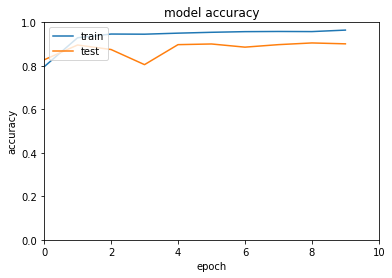

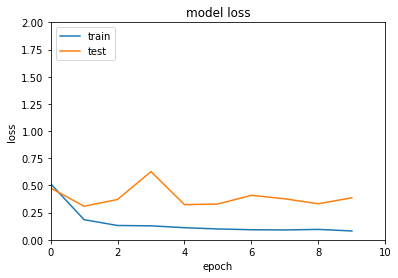

,walk,up,down,sit,stand,lay
walk,471,10,15,0,0,0
up,3,443,25,0,0,0
down,5,4,411,0,0,0
sit,0,20,0,423,43,5
stand,2,7,0,125,398,0
lay,0,27,0,0,0,510


In [19]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Training a one dimensional CNN with only a few layers shows a more stable training process. This makes sense because the gradient is not backpropagated through time but "only" through the depth of the network. It achieves the best test accuracy at 91.4%.

### Mixed CNN and RNN

In [20]:
### START YOUR CODE

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', input_shape=(128, 9)),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    SimpleRNN(units=64, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=64, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=64, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'),
    Flatten(),
    Dense(units=512, activation='relu', kernel_initializer='he_normal'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 126, 64)           1792      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 124, 64)           12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 60, 128)           24704     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 58, 128)           49280     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 29, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 27, 256)          

In [21]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 10s 37ms/step - loss: 0.9423 - accuracy: 0.6166 - val_loss: 0.4690 - val_accuracy: 0.8354
Epoch 2/10
230/230 [==============================] - 8s 34ms/step - loss: 0.2348 - accuracy: 0.9226 - val_loss: 0.3603 - val_accuracy: 0.8870
Epoch 3/10
230/230 [==============================] - 8s 34ms/step - loss: 0.1254 - accuracy: 0.9467 - val_loss: 0.3120 - val_accuracy: 0.9043
Epoch 4/10
230/230 [==============================] - 8s 34ms/step - loss: 0.1203 - accuracy: 0.9499 - val_loss: 0.3137 - val_accuracy: 0.9006
Epoch 5/10
230/230 [==============================] - 8s 34ms/step - loss: 0.1111 - accuracy: 0.9494 - val_loss: 0.3181 - val_accuracy: 0.9148
Epoch 6/10
230/230 [==============================] - 8s 35ms/step - loss: 0.0916 - accuracy: 0.9539 - val_loss: 0.3250 - val_accuracy: 0.9084
Epoch 7/10
230/230 [==============================] - 8s 34ms/step - loss: 0.0986 - accuracy: 0.9598 - val_loss: 0.4024 - val_accuracy: 0.901

Train accuracy (end): 0.9591947793960571
Train accuracy (max): 0.9605549573898315
Test accuracy (end) : 0.9182218909263611
Test accuracy (max) : 0.9212758541107178


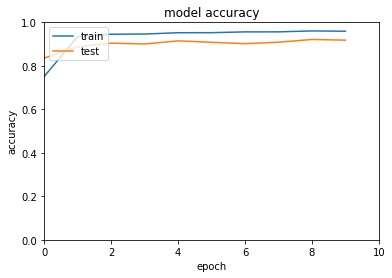

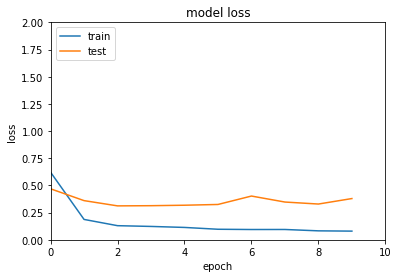

,walk,up,down,sit,stand,lay
walk,492,3,1,0,0,0
up,15,449,7,0,0,0
down,5,7,408,0,0,0
sit,0,27,0,400,63,1
stand,0,8,0,77,447,0
lay,0,27,0,0,0,510


In [22]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

The combination of 1DCNN layers and and RNN layers seems to be beneficial as the best test accuracy (92.1%) is improved a litte compared to the plain CNN model.

### Several 2D CNN Layers inc Dropout

In [28]:
### START YOUR CODE
dropout_rate = 0.2

model = Sequential()

model.add(Input(shape=(128, 9)))
model.add(Reshape((128, 9, 1)))

model.add(Conv2D(filters=16, kernel_size=(5,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=32, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=64, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=64, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
### END YOUR CODE

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 9, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 62, 9, 16)         96        
_________________________________________________________________
dropout_12 (Dropout)         (None, 62, 9, 16)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 9, 32)         1568      
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 9, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 9, 64)         6208      
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 9, 64)        

In [29]:
### START YOUR CODE
batch_size = 32
n_epochs   = 50

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50
230/230 [==============================] - 1s 4ms/step - loss: 0.8343 - accuracy: 0.6458 - val_loss: 0.5392 - val_accuracy: 0.8015
Epoch 2/50
230/230 [==============================] - 1s 4ms/step - loss: 0.3045 - accuracy: 0.8769 - val_loss: 0.4087 - val_accuracy: 0.8646
Epoch 3/50
230/230 [==============================] - 1s 3ms/step - loss: 0.2502 - accuracy: 0.9047 - val_loss: 0.3309 - val_accuracy: 0.8856
Epoch 4/50
230/230 [==============================] - 1s 3ms/step - loss: 0.1982 - accuracy: 0.9255 - val_loss: 0.3028 - val_accuracy: 0.8951
Epoch 5/50
230/230 [==============================] - 1s 4ms/step - loss: 0.1716 - accuracy: 0.9335 - val_loss: 0.2688 - val_accuracy: 0.9084
Epoch 6/50
230/230 [==============================] - 1s 4ms/step - loss: 0.1528 - accuracy: 0.9410 - val_loss: 0.2323 - val_accuracy: 0.9213
Epoch 7/50
230/230 [==============================] - 1s 4ms/step - loss: 0.1387 - accuracy: 0.9487 - val_loss: 0.2389 - val_accuracy: 0.9138
Epoch 

Train accuracy (end): 0.9866703152656555
Train accuracy (max): 0.9878944754600525
Test accuracy (end) : 0.9477434754371643
Test accuracy (max) : 0.9602985978126526


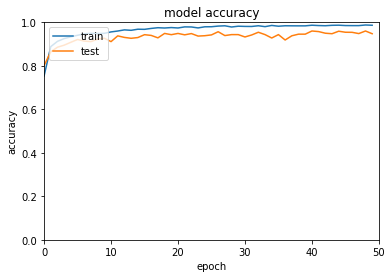

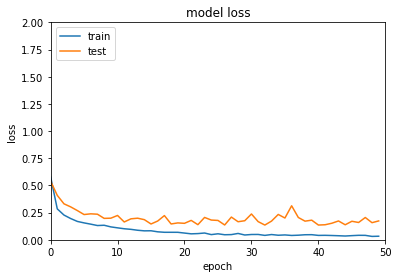

,walk,up,down,sit,stand,lay
walk,495,0,0,0,1,0
up,25,436,9,1,0,0
down,11,1,408,0,0,0
sit,0,1,0,412,78,0
stand,0,0,0,27,505,0
lay,0,0,0,0,0,537


In [30]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings
The CNN acheives a max test accuracy of 96% along with a minor amount of overfitting.

### Several 2D CNN Layers inc Dropout, with spatial coordinates as channels

In [31]:
### START YOUR CODE

dropout_rate = 0.2
start_power = 5
model = Sequential([
    Input(shape=(128, 9)),
    Reshape((128, 3, 3)),
    Conv2D(filters=2**start_power, kernel_size=(5, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+1), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+2), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+3), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Flatten(),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 128, 3, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 3, 32)         512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 62, 3, 32)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 3, 64)         6208      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 3, 64)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 3, 128)        24704     
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 3, 128)       

In [32]:
### START YOUR CODE
batch_size = 64
n_epochs   = 100

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/100
115/115 [==============================] - 1s 5ms/step - loss: 1.3050 - accuracy: 0.4600 - val_loss: 0.7251 - val_accuracy: 0.6905
Epoch 2/100
115/115 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.7060 - val_loss: 0.6493 - val_accuracy: 0.7401
Epoch 3/100
115/115 [==============================] - 0s 4ms/step - loss: 0.5114 - accuracy: 0.7830 - val_loss: 0.6569 - val_accuracy: 0.7472
Epoch 4/100
115/115 [==============================] - 0s 4ms/step - loss: 0.4478 - accuracy: 0.8170 - val_loss: 0.5759 - val_accuracy: 0.7957
Epoch 5/100
115/115 [==============================] - 0s 4ms/step - loss: 0.4083 - accuracy: 0.8310 - val_loss: 0.5562 - val_accuracy: 0.8032
Epoch 6/100
115/115 [==============================] - 0s 4ms/step - loss: 0.3548 - accuracy: 0.8571 - val_loss: 0.5281 - val_accuracy: 0.8198
Epoch 7/100
115/115 [==============================] - 0s 4ms/step - loss: 0.3175 - accuracy: 0.8719 - val_loss: 0.5035 - val_accuracy: 0.8266

Epoch 58/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9696 - val_loss: 0.2104 - val_accuracy: 0.9345
Epoch 59/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 0.9704 - val_loss: 0.2095 - val_accuracy: 0.9321
Epoch 60/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9704 - val_loss: 0.2164 - val_accuracy: 0.9342
Epoch 61/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0740 - accuracy: 0.9711 - val_loss: 0.2340 - val_accuracy: 0.9287
Epoch 62/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 0.9725 - val_loss: 0.2144 - val_accuracy: 0.9332
Epoch 63/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9771 - val_loss: 0.2044 - val_accuracy: 0.9379
Epoch 64/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.9731 - val_loss: 0.2040 - val_accuracy:

Train accuracy (end): 0.984358012676239
Train accuracy (max): 0.9859902262687683
Test accuracy (end) : 0.9243298172950745
Test accuracy (max) : 0.9416355490684509


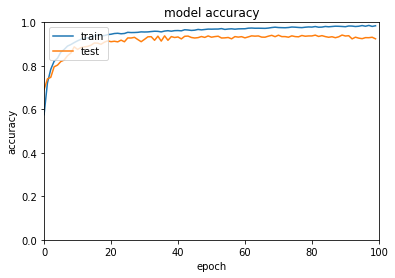

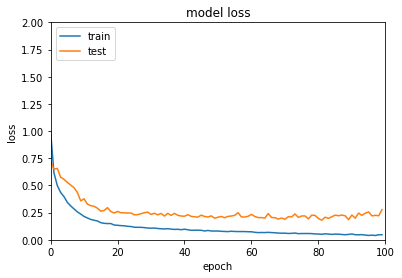

,walk,up,down,sit,stand,lay
walk,472,1,23,0,0,0
up,39,410,22,0,0,0
down,1,6,413,0,0,0
sit,0,5,0,410,74,2
stand,2,4,0,23,503,0
lay,0,7,0,0,14,516


In [33]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Using a two dimensional CNN with kernel strictly applied only in the time dimension and reshaping the input in a way such that the channel dimension corresponds to the spatial one (x, y, z) seems to be superior to the other approaches with a max test accuracy of 94.9%. This network can be interpreted as an ensemble of 1D CNN's, one for each sensor and its measurements.